In [1]:
import numpy as np
import math
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.neighbors import BallTree
from scipy.spatial import cKDTree

from copy import deepcopy
from tqdm.notebook import tqdm
from time import sleep, time
from IPython.display import clear_output

from cycler import cycler

colors = cycler(color=plt.get_cmap('tab10').colors) # b, r, g

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams['axes.prop_cycle'] = colors
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['legend.loc'] = 'upper right'

In [23]:
class Number:
  """data descriptor, checking the type of variables"""
  @classmethod
  def verify_coord(cls, coord):
    if not(isinstance(coord, int) or isinstance(coord, float)):
      return True
    if coord < 0:
      return True

  def __set_name__(self, owner, name):
    self.name = "_" + name

  def __get__(self, instance, owner):
    return getattr(instance, self.name)

  def __set__(self, instance, value):
    if self.verify_coord(value):
      raise TypeError(f"{self.name} must be a positive number!")
    setattr(instance, self.name, value)
  
class System:
  """Class with system properties"""  
  __box_size_x = Number()
  __box_size_y = Number()
  __box_size_z = Number()
  __t_required = Number()

  def __init__(self, box_size_x=50, box_size_y=50, box_size_z=0, t_required=90, nparticles=100):
    self.__box_size_x = box_size_x
    self.__box_size_y = box_size_y
    self.__box_size_z = box_size_z
    self.__t_required = t_required
    self.verify_int(nparticles)
    self.__nparticles = nparticles
  
  @property
  def box_sizes(self):
    return np.array((self.__box_size_x, self.__box_size_y, self.__box_size_z))

  @property
  def t_required(self):
    return self.__t_required

  @t_required.setter
  def t_required(self, t_required):
    self.__t_required = t_required

  @property
  def nparticles(self):
    return self.__nparticles

  @nparticles.setter
  def nparticles(self, nparticles):
    self.verify_int(nparticles)
    self.__nparticles = nparticles

  @classmethod
  def verify_int(cls, arg):
    """check if the variable is a positive integer"""
    if type(arg) != int:
      raise TypeError("the number of particles must be an integer!")
    if arg < 0:
      raise TypeError('the number of particles must be a positive integer')

  @property
  def box_dim(self):
    return np.count_nonzero(np.array((self.__box_size_x, self.__box_size_y, self.__box_size_z)))

class Particle:
  """Class for system particles, with its properties"""
  # Boltzman constant
  __BOLTZMAN_CONSTANT = 1.380649e-23
  # Constant for converting meters to angstroms
  __METERS_TO_ANGSTROMS = 1e+10
  # correction for the center of the potential well
  __LJ_MINIMUM_POTENTIAL = 2**(1/6)

  __sigma = Number()
  __mass = Number()
  __calibration_parameter = Number()

  def __init__(self, sigma=1, mass=6.634e-26, calibration_parameter=1, system_condition=System()):
    self.__sigma = sigma
    self.__sigma_eps = (self.__LJ_MINIMUM_POTENTIAL - 1) * sigma * calibration_parameter
    self.__mass = mass

    self.__coord = self.__get_initial_coord(system_condition.box_sizes, system_condition.nparticles)
    self.__speed = self.__get_initial_speeds(system_condition.box_sizes, system_condition.nparticles, system_condition.t_required)
  
  def __get_initial_coord(self, box_sizes, nparticles):
    """creating particles in a box with random initial coordinates
    
    Parameters
    -----------
    box_sizes : numpy array
      Box sizes in angstrom, it can be either 2D or 3D.
    nparticles : int
      The number of particles in the system.
    
    Returns
    -----------
    cooord : numpy array
      Coordinates of all particles in the box with
      size (nparticles, box_sizes.shape), [A]
    """
    count = np.count_nonzero(box_sizes)
    coord = np.zeros(shape=[1, count])
    candidate = np.zeros(shape=[1, count])
    # np.random.seed(0)
    for ids in range(count):
      coord[0,ids] = np.random.uniform(0, box_sizes[ids])
    min_dist = self.__sigma+self.__sigma_eps
    i = 1
    pbar = tqdm(desc='creating particles', total = nparticles)
    while i < nparticles:
      for ids in range(count):
        candidate[0, ids] = np.random.uniform(0, box_sizes[ids])
      tree_coord = cKDTree(coord, leafsize=30, balanced_tree=True, compact_nodes=True, boxsize=box_sizes[:count]) #create a tree to find nearest neighbors
      if len(tree_coord.query_ball_point(candidate.squeeze(), r = min_dist)) == 0: #see if there are other particles nearby
        coord = np.append(coord, candidate, axis=0) #create a particle if there are no others nearby
        i += 1
        pbar.update()
    pbar.update() #this is needed since we started with i = 1
    pbar.close()
    return coord
  
  def __get_initial_speeds(self, box_sizes, nparticles, t_required):
    """creation of initial velocities for particles
    
    Parameters
    -----------
    box_sizes : numpy array
      Box sizes in angstrom, it can be either 2D or 3D.
    nparticles : int
      The number of particles in the system.
    t_required : int, float
      initial temperature of the system in kelvins.
    
    Returns
    -----------
    speed : numpy array
      Speeds of all particles in the box with
      size (nparticles, box_sizes.shape), [A/s]
    """
    count = np.count_nonzero(box_sizes)
    cvm = np.zeros(shape=[1, count])
    # np.random.seed(0)
    speed = np.random.uniform(-0.5, 0.5, nparticles * count).reshape(nparticles, count)
    for ids in range(count):
      cvm[0, ids] = speed[:, ids].sum()/nparticles
    for ids in range(count):
      for i in range(nparticles):
        speed[i, ids] -= cvm[0, ids]
    T_temp = np.square(speed).sum()*self.__mass/self.__BOLTZMAN_CONSTANT/nparticles/count
    scale = math.sqrt(t_required/T_temp)
    speed = np.multiply(scale, speed)
    return speed * self.__METERS_TO_ANGSTROMS

  @property
  def coord(self):
    return self.__coord

  @property
  def speed(self):
    return self.__speed

  @property
  def mass(self):
    return self.__mass

  @mass.setter
  def mass(self, mass):
    self._mass = mass

  @property
  def sigma(self):
    return self.__sigma
  
  @sigma.setter
  def sigma(self, sigma):
    self.__sigma = sigma

class Model:
  # coefficients in the formula for the lenard jones potential.
  __COEFFICIENT_LJ = 4
  __COEFFICIENT_LJ_DIFF = 48
  __DIFF_COEF = 0.5
  # taking into account the double counting of potential energy.
  __DOUBLE_COUNT = 0.5
  # Boltzman constant.
  __BOLTZMAN_CONSTANT = 1.380649e-23 
  # 1/2 for the kinetic energy formula.
  __KINETIC_ENERGY_CONSTANT = 0.5 
  # v(t+0.5dt) formula LJ constant.
  __VELOCITY_LJ_CONSTANT = 0.5 
  # Constant for converting angstroms to meters.
  __ANGSTROMS_TO_METERS = 1e-10
  
  def __init__(self, nparticles, t_required, box_size_x, box_size_y, 
               box_size_z, sigma, mass, calibration_parameter):
    self.__system = System(box_size_x, box_size_y, box_size_z, t_required, nparticles)
    self.__particles = Particle(sigma, mass, calibration_parameter, system_condition=self.__system)

  def __get_force_cKDTree(self, nparticles, coord, epsilon, sigma12, sigma6, r_cut, dim, box_sizes):
    """calculation of forces in the system with cKDTree method
    
    Parameters
    -----------
    nparticles : int
      The number of particles in the system.
    coord: numpy array
      array with coordinates of the particles.
    epsilon: float
      the depth of the potential well. [kg/(A*s)^2]
    sigma12: float
      12 degree of sigma. [A^12]
    sigma6: float
      6 degree of sigma. [A^6]
    r_cut: float
      potential cutoff radius. [A]
    dim: int
      the number of box dimensions.
    box_sizes: numpy array
      Box sizes in angstrom, it can be either 2D or 3D.
    
    Returns
    -----------
    potential_energy: float
      potential energy of the system. [kg/(A*s)^2]
    force: numpy array
      forces of the system. [kg*A/s^2]
    """
    force = np.zeros(shape=[nparticles, dim])
    potential_energy = 0
    tree = cKDTree(coord, leafsize=30, balanced_tree=True, compact_nodes=True, boxsize=box_sizes[:dim])
    for idx1 in range(nparticles):
      index = tree.query_ball_point([coord[idx1]], r=r_cut)
      for idx2 in range(len(index[0])):
        if (index[0][idx2]==idx1):
          continue
        r = coord[idx1] - coord[index[0][idx2]]
        for idx3 in range(dim):
          if r[idx3] > 0.5 * box_sizes[idx3]: r[idx3] -= box_sizes[idx3]
          if r[idx3] < -0.5 * box_sizes[idx3]: r[idx3] += box_sizes[idx3]

        r2 = np.square(r).sum()
        r_6 = 1/r2**3
        potential_energy += self.__COEFFICIENT_LJ * epsilon * (sigma12 * r_6 * r_6 - sigma6 * r_6)
        f_vec = self.__COEFFICIENT_LJ_DIFF * epsilon * (sigma12 * r_6 * r_6 - self.__DIFF_COEF * sigma6 * r_6)
        force[idx1] += r * f_vec
    return potential_energy * self.__DOUBLE_COUNT, force

  def __get_force_BruteForce(self, nparticles, coord, epsilon, sigma12, sigma6, r_cut, dim, box_sizes):
    """calculation of forces in the system with BruteForce method
    
    Parameters
    -----------
    nparticles : int
      The number of particles in the system.
    coord: numpy array
      array with coordinates of the particles.
    epsilon: float
      the depth of the potential well. [kg/(A*s)^2]
    sigma12: float
      12 degree of sigma. [A^12]
    sigma6: float
      6 degree of sigma. [A^6]
    r_cut: float
      potential cutoff radius. [A]
    dim: int
      the number of box dimensions.
    box_sizes: numpy array
      Box sizes in angstrom, it can be either 2D or 3D.

    Returns
    -----------
    potential_energy: float
      potential energy of the system. [kg/(A*s)^2]
    force: numpy array
      forces of the system. [kg*A/s^2]
    """
    force = np.zeros(shape=[nparticles, dim])
    potential_energy = 0
    r_cut2 = r_cut**2
    for idx1 in range(nparticles-1):
      for idx2 in range(idx1+1, nparticles):
        r = coord[idx1] - coord[idx2]
        for idx3 in range(dim):
          if r[idx3] > 0.5 * box_sizes[idx3]: r[idx3] -= box_sizes[idx3]
          if r[idx3] < -0.5 * box_sizes[idx3]: r[idx3] += box_sizes[idx3]
        
        r2 = np.square(r).sum()
        if r2 < r_cut2:
          r_6 = 1/r2**3
          potential_energy += self.__COEFFICIENT_LJ * epsilon * (sigma12 * r_6 * r_6 - sigma6 * r_6)
          f_vec = self.__COEFFICIENT_LJ_DIFF * epsilon * (sigma12 * r_6 * r_6 - self.__DIFF_COEF * sigma6 * r_6)
          force[idx1] += r * f_vec
          force[idx2] -= r * f_vec
    return potential_energy, force

  def __get_simple_thermostat(self, speed, t_required, mass, nparticles, dim):
    """a simple thermostat to control the temperature of the system
    
    Parameters
    -----------
    speed: numpy array
      array with speeds of the particles.
    t_required: float
      required temperature of the system in kelvins.
    mass: float
      mass of the particle [kg]
    nparticles: int
      The number of particles in the system.
    dim: int
      the number of box dimensions.

    Returns
    -----------
    speed_scaled: numpy array
      speeds of the particles after scaling [A/s]
    """
    T_temp = np.square(speed*1e-10).sum()*mass/self.__BOLTZMAN_CONSTANT/nparticles/dim
    scale = math.sqrt(t_required/T_temp)
    speed_scaled = np.multiply(scale, speed)
    return speed_scaled

  def __get_g_calculation(self, nparticles, resolution, volumes, coord, dr, g_cut, g_of_r, dim, box_sizes):
    """pair correlation function calculation
    
    Parameters
    -----------
    nparticles: int
      The number of particles in the system.
    resolution: int
      the number of spheres dividing the space.
    volumes: numpy array
      an array with the volume of these spheres
    coord: numpy array
      array with coordinates of the particles.
    dr: float
      distance between adjacent spheres.
    g_cut: float
      the cutoff radius of the calculation of the pair correlation function.
    g_of_r: numpy array
      array with pair correlation function values.
    dim: int
      the number of box dimensions.

    Returns
    -----------
    g_of_r: numpy array
      updated array with pair correlation function values.
    volumes: numpy array
      an array with the volume of these spheres at this step.
    """
    for idx1 in range(nparticles):
      for idx2 in range(resolution):
        r1 = idx2 * dr #inner radii of shell
        r2 = r1 + dr #external radii of shell
        v1 = math.pi * r1**2 
        v2 = math.pi * r2**2 #v_external - v_inner = v_shell
        volumes[idx2] += v2 - v1 #Add volumes (areas in case of 2D) to an array (histogram)
    
    tree = cKDTree(coord, leafsize=30, balanced_tree=True, compact_nodes=True, boxsize=box_sizes[:dim])
    for idx1 in range(nparticles):
      distance = tree.query_ball_point([coord[idx1]], r=g_cut)
      for idx2 in range(len(distance[0])):
        if (distance[0][idx2]==idx1):
          continue
        r = coord[idx1] - coord[distance[0][idx2]]
        for idx3 in range(dim):
          if r[idx3] > 0.5 * box_sizes[idx3]: r[idx3] -= box_sizes[idx3]
          if r[idx3] < -0.5 * box_sizes[idx3]: r[idx3] += box_sizes[idx3]
        len_r = np.sqrt(r.dot(r))
        index = int(len_r / dr)
        if 0 < index < resolution:
          g_of_r[index] += 1
    return g_of_r, volumes
  
  def __get_sigma(self, lattice_translation, coord, initial_coord, nparticles):
    """system MSD calculation
    
    Parameters
    -----------
    lattice_translation: numpy array
      an array with the number of translations of the particle, 
      when it goes beyond the box.
    coord: numpy array
      array with coordinates of the particles.
    initial_coord: numpy array
      array with initial coordinates of the particles.
    nparticles: int
      The number of particles in the system.

    Returns
    -----------
    sigma_i: float
      MSD at this time step.
    """
    coords_sigma = coord + lattice_translation #consideration of boundary conditions, since MSD is valid only for open boxes
    sigma_i = np.square(coords_sigma - initial_coord).sum()/(nparticles) #its r**2 mean - MSD
    return sigma_i
  
  def __velocity_verlet_time_step(self, method, nparticles, coord, speed, time_step, mass, lattice_translation, epsilon, sigma12, sigma6, r_cut, dim, box_sizes):
    """molecular dynamics velocity verlet algorithm
    
    Parameters
    -----------
    method: str
      choice of method for calculating the forces of the system.
    nparticles: int
      The number of particles in the system.
    coord: numpy array
      array with coordinates of the particles.
    speed: numpy array
      array with speeds of the particles.
    time_step: float
      time step for molecular dynamics. [s]
    mass: float
      mass of the particle [kg]
    lattice_translation: numpy array
      an array with the number of translations of the particle, 
      when it goes beyond the box.
    epsilon: float
      the depth of the potential well. [kg/(A*s)^2]
    sigma12: float
      12 degree of sigma. [A^12]
    sigma6: float
      6 degree of sigma. [A^6]
    r_cut: float
      potential cutoff radius. [A]
    dim: int
      the number of box dimensions.
    box_sizes: numpy array
      Box sizes in angstrom, it can be either 2D or 3D.

    Returns
    -----------
    coord: numpy array
      array with coordinates of the particles.
    speed: numpy array
      array with speeds of the particles.
    potential_energy: float
      potential energy of the system. [eV]
    kinetic_energy: float
      kinetic energy of the system. [eV]
    T_system_real: float
      temperature of the system in kelvins. [K]
    """
    potential, force = self.__get_method(method, nparticles, coord, epsilon, sigma12, sigma6, r_cut, dim, box_sizes)
    potential_energy, kinetic_energy, T_system_real = self.__get_system_condition(potential, mass, speed, nparticles, dim)
    for idx1 in range(nparticles):
      speed[idx1] += self.__VELOCITY_LJ_CONSTANT * force[idx1] * time_step / mass
      coord[idx1] += speed[idx1] * time_step
      coord[idx1], lattice_translation[idx1] = self.__boundary_condition(coord[idx1], lattice_translation[idx1], dim, box_sizes)
    potential, force = self.__get_method(method, nparticles, coord, epsilon, sigma12, sigma6, r_cut, dim, box_sizes)
    for idx1 in range(nparticles):
      speed[idx1] += self.__VELOCITY_LJ_CONSTANT * (force[idx1] / mass) * time_step
    return coord, speed, potential_energy, kinetic_energy, T_system_real

  def __get_system_condition(self, potential, mass, speed, nparticles, dim):
    """obtaining system characteristics in eV at this step
    
    Parameters
    -----------
    potential: float
      potential energy of the system. [eV]
    mass: float
      mass of the particle [kg]
    speed: numpy array
      array with speeds of the particles.
    nparticles: int
      The number of particles in the system.
    dim: int
      the number of box dimensions.

    Returns
    -----------
    potential_energy: float
      potential energy of the system. [eV]
    kinetic_energy: float
      kinetic energy of the system. [eV]
    T_system_real: float
      temperature of the system in kelvins. [K]
    """
    potential_energy = (potential * self.__ANGSTROMS_TO_METERS**2) / 1.6e-19
    kinetic_energy = self.__KINETIC_ENERGY_CONSTANT * mass * np.square(speed * self.__ANGSTROMS_TO_METERS).sum() / 1.6e-19
    T_system_real = mass * np.square(speed * self.__ANGSTROMS_TO_METERS).sum() / nparticles / self.__BOLTZMAN_CONSTANT / dim
    return potential_energy, kinetic_energy, T_system_real
    
  def __boundary_condition(self, coord, lattice_translation, dim, box_sizes):
    """taking into account the boundary conditions 
    and counting the number of particle translations
    
    Parameters
    -----------
    coord: numpy array
      array with coordinates of the particles.
    lattice_translation: numpy array
      an array with the number of translations of the particle, 
      when it goes beyond the box.
    dim: int
      the number of box dimensions.
    box_sizes: numpy array
      Box sizes in angstrom, it can be either 2D or 3D.

    Returns
    -----------
    coord: numpy array
      array with coordinates of the particles.
    lattice_translation: numpy array
      updated array with the number of translations of the particle, 
      when it goes beyond the box.
    """
    for idx3 in range(dim):
      while coord[idx3] < 0:
        coord[idx3] += box_sizes[idx3]
        lattice_translation[idx3] -= box_sizes[idx3]
      while coord[idx3] > box_sizes[idx3]:
        coord[idx3] -= box_sizes[idx3]
        lattice_translation[idx3] += box_sizes[idx3]
    return coord, lattice_translation
  
  def __get_method(self, method, nparticles, coord, epsilon, sigma12, sigma6, r_cut, dim, box_sizes):
    """choice of method for calculating the forces of the system.
    
    Parameters
    -----------
    method: str
      choice of method for calculating the forces of the system.
    nparticles: int
      The number of particles in the system.
    coord: numpy array
      array with coordinates of the particles.
    epsilon: float
      the depth of the potential well. [kg/(A*s)^2]
    sigma12: float
      12 degree of sigma. [A^12]
    sigma6: float
      6 degree of sigma. [A^6]
    r_cut: float
      potential cutoff radius. [A]
    dim: int
      the number of box dimensions.
    box_sizes: numpy array
      Box sizes in angstrom, it can be either 2D or 3D.

    Returns
    -----------
    potential: float
      potential energy of the system.
    force: numpy array
      forces in the system. [K]
    """
    if method.lower() == 'ckdtree':
      potential, force = self.__get_force_cKDTree(nparticles, coord, epsilon, sigma12, sigma6, r_cut, dim, box_sizes)
    elif method.lower() == 'bruteforce':
      potential, force = self.__get_force_BruteForce(nparticles, coord, epsilon, sigma12, sigma6, r_cut, dim, box_sizes)
    else:
      raise ValueError('Only two methods can be selected: ckdtree, bruteforce')
    return potential, force

  def run(self, time_step, resolution, number_of_steps, method, thermo, g_of_r_method, 
          MSD_method, warm_up_time, epsilon, r_cut):
    """molecular dynamics
    
    Parameters
    -----------
    time_step: float
      time step for dynamics.
    resolution: int
      the number of spheres dividing the space.
    number_of_steps: int
      number of molecular dynamics steps.
    method: str
      choice of method for calculating the forces of the system.
    thermo: bool
      thermostat control
    g_of_r_method: bool
      g_of_r calculation on/off
    MSD_method: bool
      MSD calculation on/off
    warm_up_time: int
      System warm-up time, for calculating the 
      pair correlation function.
    epsilon: float
      the depth of the potential well. [kg/(A*s)^2]
    r_cut: float
      potential cutoff radius. [A]

    Returns
    -----------
    potential_energy: numpy array
      potential energy of the system. [eV]
    coord: numpy array
      array with coordinates of the particles.
    speed: numpy array
      array with speeds of the particles.
    g_of_r: numpy array
      array with pair correlation function values.
    sigma: numpy array
      MSD at every time step.
    kinetic_energy: numpy array
      kinetic energy of the system. [eV]
    total_time: float
      run time of the molecular dynamics.
    """
    run_time = 0
    
    nparticles = self.__system.nparticles
    dim = self.__system.box_dim
    box_sizes = self.__system.box_sizes
    t_required = self.__system.t_required

    coord = self.__particles.coord
    speed = self.__particles.speed
    mass = self.__particles.mass
    sigma = self.__particles.sigma

    sigma12 = sigma**12
    sigma6 = sigma**6

    # Preparation for calculating g_of_r
    if g_of_r_method:
      volume_per_atom = np.prod(box_sizes[np.nonzero(box_sizes)])/(nparticles)
      g_cut = np.min(box_sizes[np.nonzero(box_sizes)]) / 2
      dr = g_cut / resolution
      volumes = np.zeros(resolution)
      g_of_r = np.zeros(resolution)

    # Preparation for calculating MSD
    sigma = np.zeros(number_of_steps)
    initial_coord = coord.copy()
    lattice_translation = np.zeros_like(coord)
    
    # Zeros arrays for energies
    potential_energy = np.zeros(number_of_steps)
    kinetic_energy = np.zeros(number_of_steps)

    # tqdm to visualize
    tk0 = tqdm(desc='molecular dynamics', total = number_of_steps)
    start = time()
    # MD simulation
    for idx_t in range(number_of_steps):
      coord, speed, potential_energy[idx_t], kinetic_energy[idx_t], T_system_real = self.__velocity_verlet_time_step(method, nparticles, coord, speed, time_step, mass, lattice_translation, epsilon, sigma12, sigma6, r_cut, dim, box_sizes)
      
      # simple thermostat for T = const
      if thermo:
        speed = self.__get_simple_thermostat(speed, t_required, mass, nparticles, dim)
      
      # g of r calculation
      if g_of_r_method and idx_t > warm_up_time:
        g_of_r, volumes = self.__get_g_calculation(nparticles, resolution, volumes, coord, dr, g_cut, g_of_r, dim, box_sizes)
      
      # MSD calculation
      if MSD_method:
        sigma[idx_t] = self.__get_sigma(lattice_translation, coord, initial_coord, nparticles)
      
      # update tk0 and print some stuff
      tk0.update()
      tk0.set_postfix(T_sys=T_system_real, Energy=(kinetic_energy[idx_t] + potential_energy[idx_t]))

    total_time = time() - start
    if g_of_r_method:
      for idx, value in enumerate(g_of_r):
        g_of_r[idx] = value * volume_per_atom/volumes[idx]
    else:
      g_of_r = None
    print(f'RUN TIME: {total_time}')
    tk0.close()

    self.potential_energy = potential_energy
    self.kinetic_energy = kinetic_energy
    self.g_of_r = g_of_r
    self.MSD = sigma
    self.run_time = total_time

    self.resolution = resolution
    self.time_step = time_step
    self.number_of_steps = number_of_steps
    self.epsilon = epsilon

  def get_plot(self):
    """build some graphs after running the program
    """
    nparticles = self.__system.nparticles
    box_sizes = self.__system.box_sizes
    t_required = self.__system.t_required

    coord = self.__particles.coord
    sigma = self.__particles.sigma

    radii = np.linspace(0.0, np.min(box_sizes[np.nonzero(box_sizes)]) / 2, self.resolution) 
    time_for_sigma = np.linspace(0, self.time_step*(self.number_of_steps), self.number_of_steps)

    plt.subplot(221)
    plt.plot(radii, self.g_of_r, label = 'g(r)')
    plt.plot([1, 1], [0, max(self.g_of_r)], '--', label = '\u03C3')
    plt.plot([0, max(radii)], [1,1], '--', label = 'g(r) = 1')
    plt.xlabel('r, A')
    plt.ylabel('g(r)')
    plt.text(max(radii)/2, max(self.g_of_r)/3, f'''T_LJ = {round(t_required*self.__BOLTZMAN_CONSTANT/(self.epsilon*self.__ANGSTROMS_TO_METERS**2), 2)} 
            \nDensity_LJ = {round(nparticles * sigma**2 / np.prod(box_sizes[np.nonzero(box_sizes)]), 2)}''')
    plt.legend()

    plt.subplot(222)
    fit = np.polyfit(time_for_sigma, self.MSD, 2)
    plt.plot(time_for_sigma, self.MSD, label = '\u03C3')
    plt.plot(time_for_sigma, fit[2] + fit[1] * pow(time_for_sigma, 1) + fit[0] * pow(time_for_sigma, 2), label = 'best fit for $x^2$')
    plt.xlabel('Time, sec')
    plt.ylabel('MSD, A')
    plt.title(f'max(\u03C3) = {round(max(self.MSD),2)} A')
    plt.legend(loc='upper left')

    plt.subplot(223)
    plt.plot(time_for_sigma, (self.kinetic_energy + self.potential_energy) / nparticles, label = 'Full energy')
    plt.xlabel('time, sec')
    plt.ylabel('Energy, eV/N')
    plt.legend()

    plt.subplot(224)
    plt.plot(coord[:,0], coord[:,1], 'ro', label = 'particles')
    plt.xlabel('X, angstrom')
    plt.ylabel('Y, angstrom')
    plt.legend()
    plt.show()

# GAS SOLUTION

In [28]:
# System
T_REQURED = 180
BOX_SIZE_X = 30
BOX_SIZE_Y = 30
BOX_SIZE_Z = 0
N_PARTICLES = 50

# Particle
MASS = 6.634e-26
SIGMA = 1
CALIBRATION_PARAMETER = 1

# Model
EPSILON = 1.653e-1
R_CUT = 4 * SIGMA
TIME_STEP = 1e-15
NUMBER_OF_STEPS = 15000
# Dependence of g on r parameters
RESOLUTION = 300
WARM_UP_TIME = 1000

In [25]:
Gas_model = Model(nparticles=N_PARTICLES, t_required=T_REQURED, box_size_x=BOX_SIZE_X, box_size_y=BOX_SIZE_Y, box_size_z=BOX_SIZE_Z, 
                    sigma=SIGMA, mass=MASS, calibration_parameter=CALIBRATION_PARAMETER)

creating particles:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
potential_energy, coord, speed, g_of_r, MSD, kinetic_energy, total_time = Gas_model.run(time_step=TIME_STEP, resolution=RESOLUTION, number_of_steps=NUMBER_OF_STEPS, method='ckdtree',
                                                                                          thermo=True, g_of_r_method=True, MSD_method=True, warm_up_time=WARM_UP_TIME, epsilon=EPSILON, r_cut=R_CUT)

molecular dynamics:   0%|          | 0/15000 [00:00<?, ?it/s]

RUN TIME: 1079.1082425117493


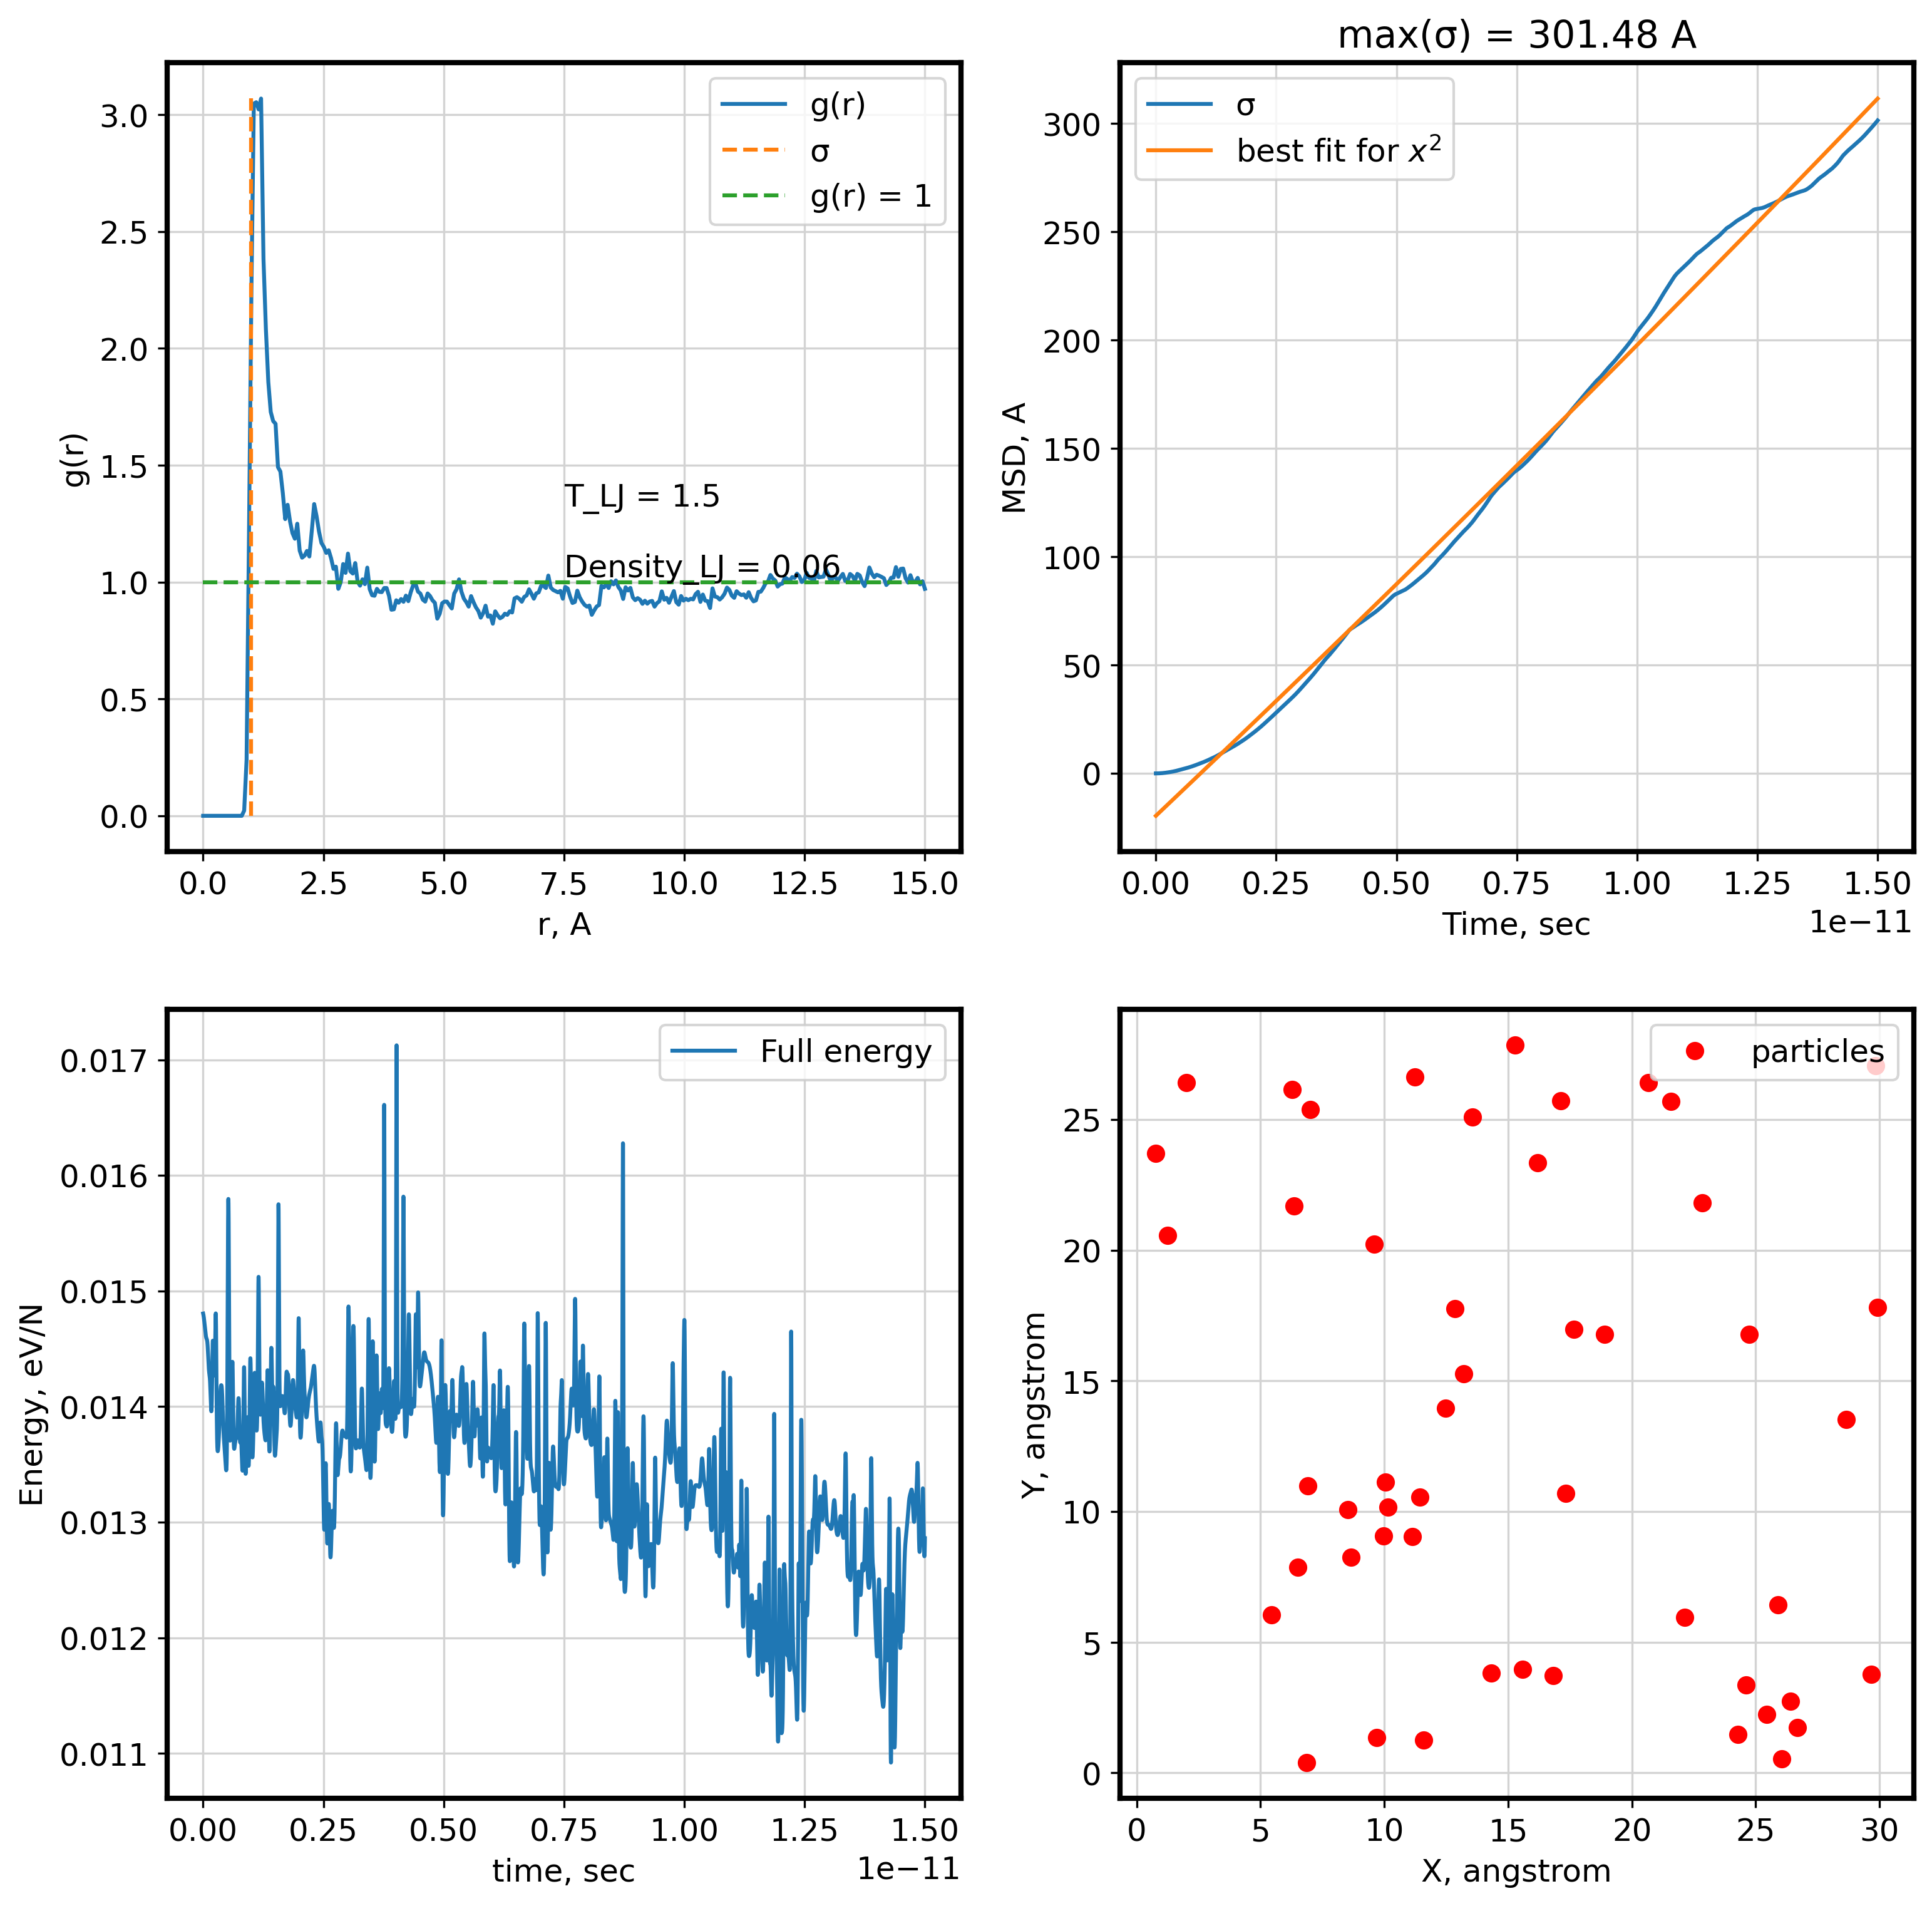

In [ ]:
Gas_model.get_plot()

# LIQUID SOLUTION

In [ ]:
# System
T_REQURED = 145
BOX_SIZE_X = 10
BOX_SIZE_Y = 10
BOX_SIZE_Z = 0
N_PARTICLES = 83

# Particle
MASS = 6.634e-26
SIGMA = 1
CALIBRATION_PARAMETER = -1.2

# Model
EPSILON = 1.653e-1
R_CUT = 4 * SIGMA
TIME_STEP = 1e-15
NUMBER_OF_STEPS = 15000
# Dependence of g on r parameters
RESOLUTION = 300
WARM_UP_TIME = 1000

In [ ]:
Liquid_model = Model(nparticles=N_PARTICLES, t_required=T_REQURED, box_size_x=BOX_SIZE_X, box_size_y=BOX_SIZE_Y, box_size_z=BOX_SIZE_Z, 
                    sigma=SIGMA, mass=MASS, calibration_parameter=CALIBRATION_PARAMETER)

creating particles:   0%|          | 0/83 [00:00<?, ?it/s]

In [ ]:
potential_energy, coord, speed, g_of_r, MSD, kinetic_energy, total_time = Liquid_model.run(time_step=TIME_STEP, resolution=RESOLUTION, number_of_steps=NUMBER_OF_STEPS, method='ckdtree',
                                                                                          thermo=True, g_of_r_method=True, MSD_method=True, warm_up_time=WARM_UP_TIME, epsilon=EPSILON, r_cut=R_CUT)

molecular dynamics:   0%|          | 0/15000 [00:00<?, ?it/s]

RUN TIME: 4235.36506986618


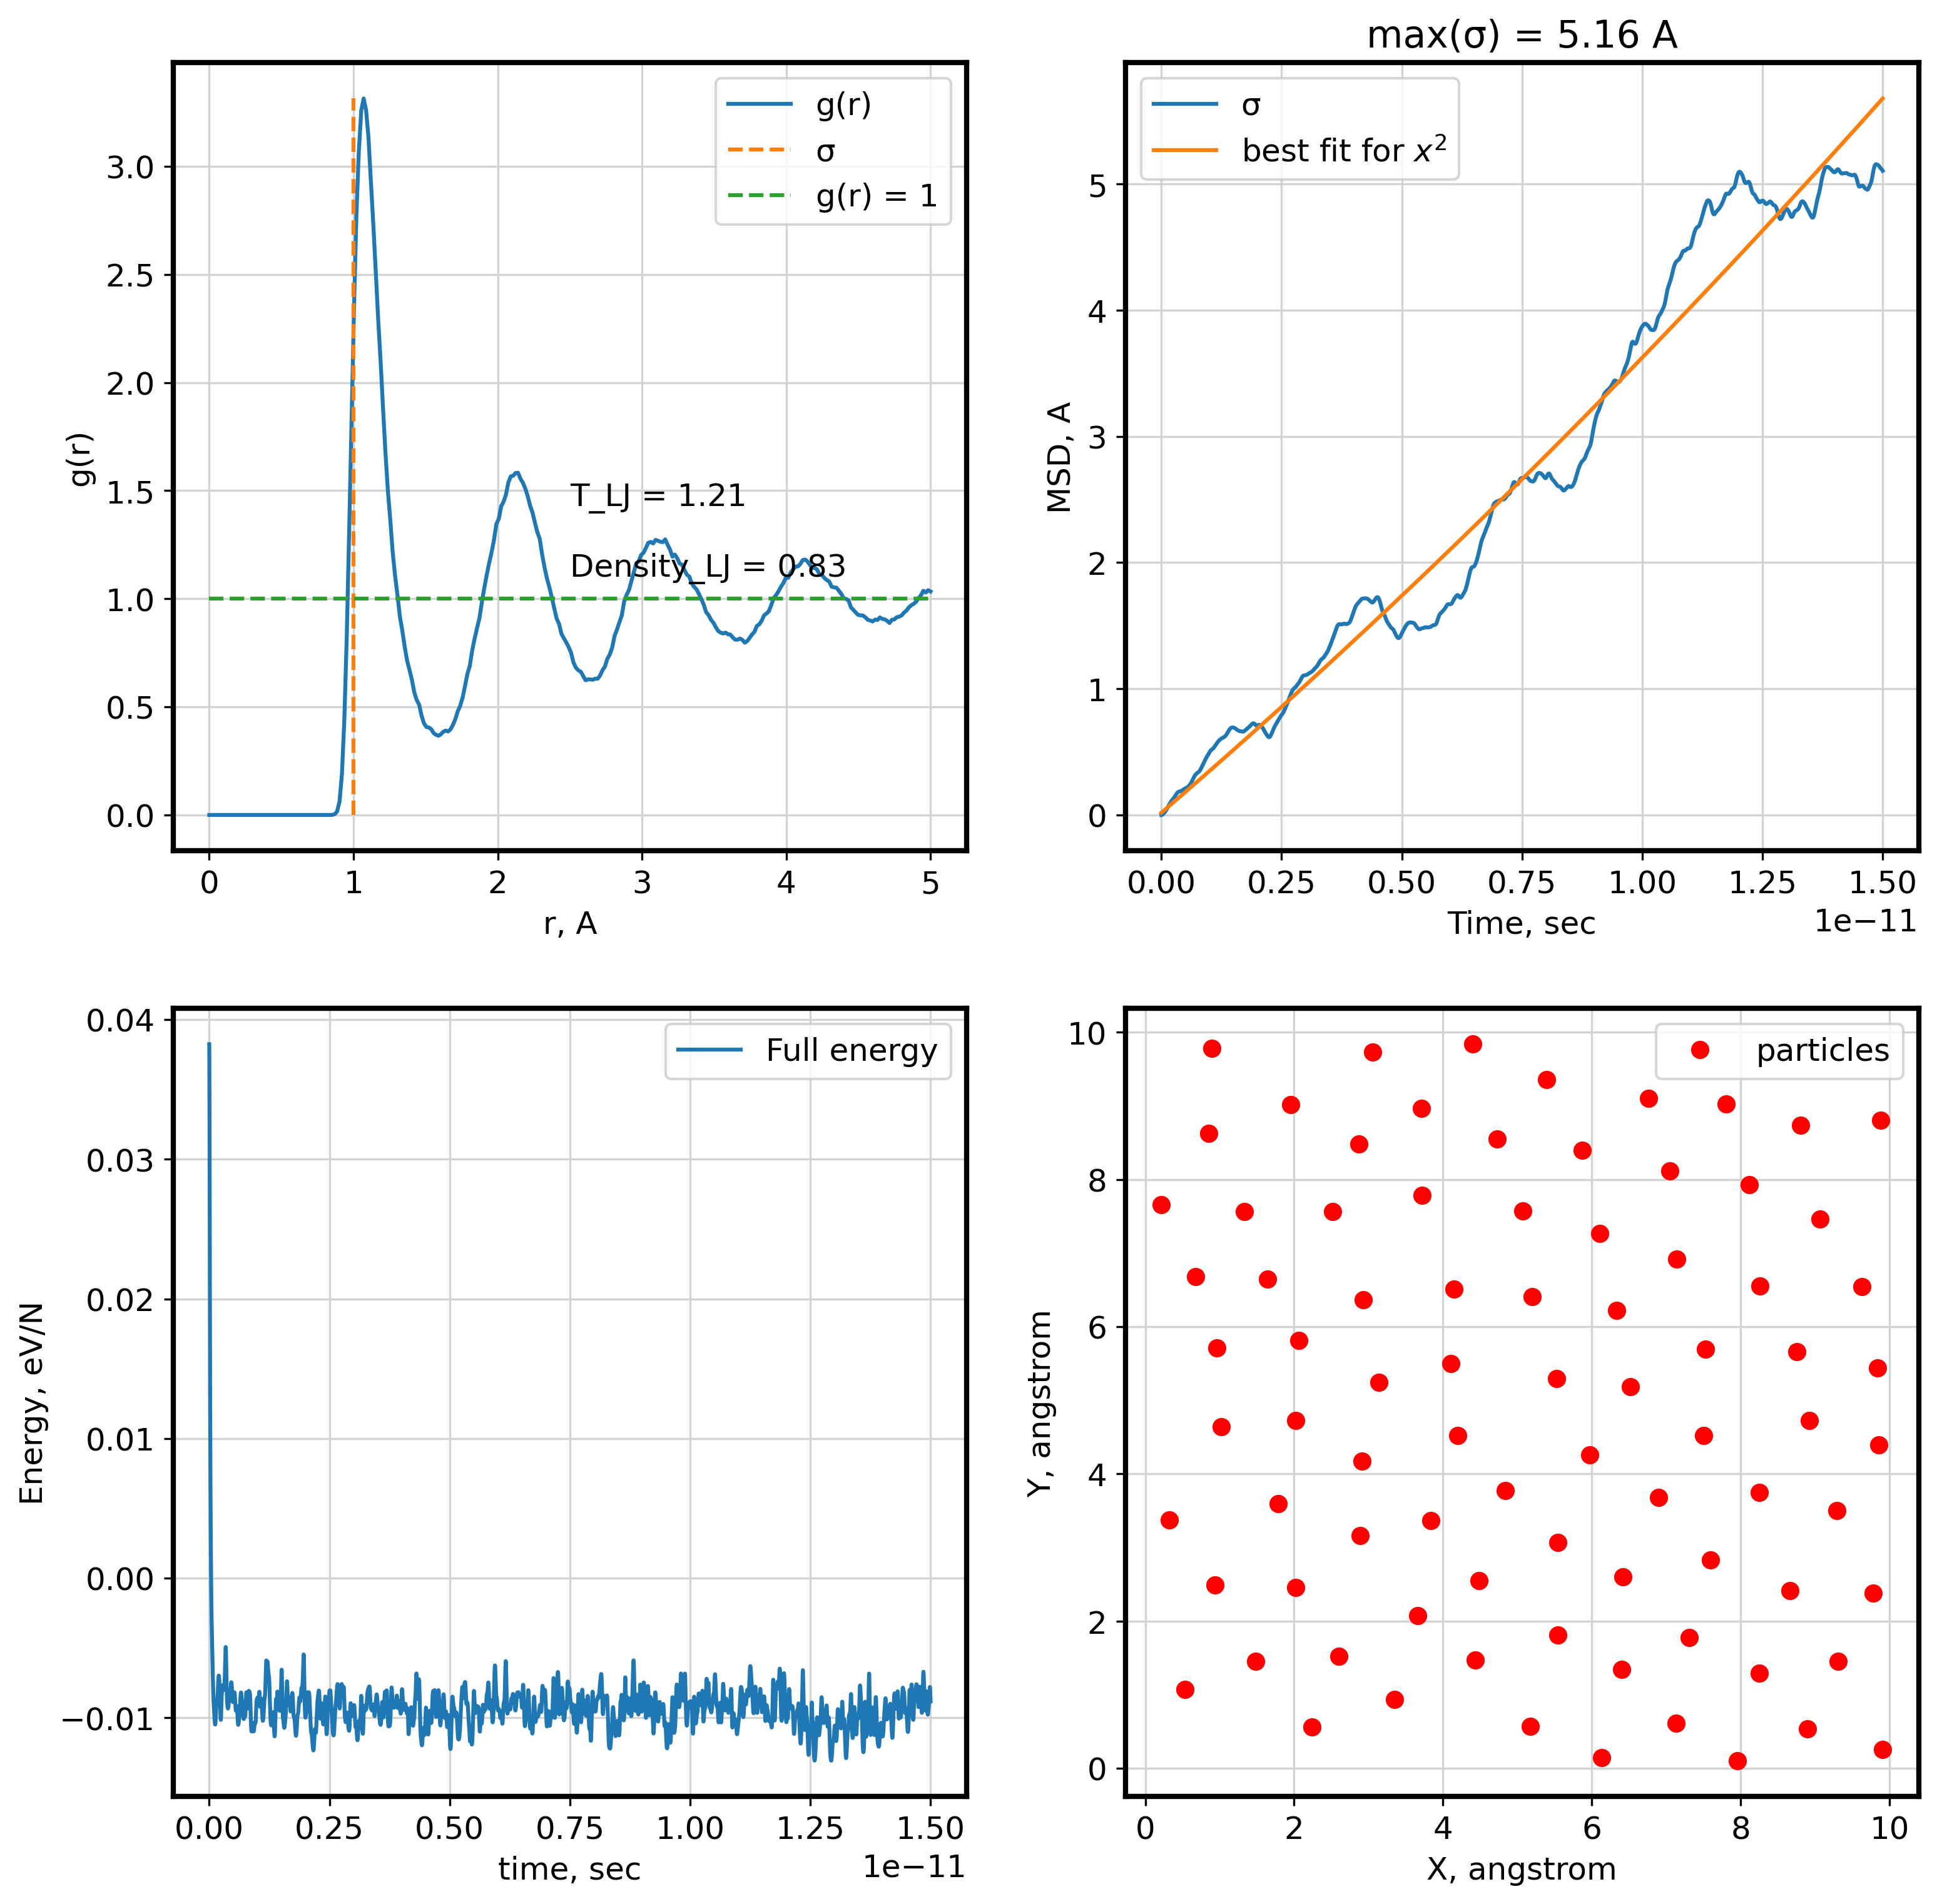

In [ ]:
Liquid_model.get_plot()

# SOLID SOLUTION

In [ ]:
# System
T_REQURED = 20
BOX_SIZE_X = 10
BOX_SIZE_Y = 10
BOX_SIZE_Z = 0
N_PARTICLES = 120

# Particle
MASS = 6.634e-26
SIGMA = 1
CALIBRATION_PARAMETER = -2.05

# Model
EPSILON = 1.653e-1
R_CUT = 4 * SIGMA
TIME_STEP = 1e-15
NUMBER_OF_STEPS = 15000
# Dependence of g on r parameters
RESOLUTION = 300
WARM_UP_TIME = 1000

In [ ]:
Solid_model = Model(nparticles=N_PARTICLES, t_required=T_REQURED, box_size_x=BOX_SIZE_X, box_size_y=BOX_SIZE_Y, box_size_z=BOX_SIZE_Z, 
                    sigma=SIGMA, mass=MASS, calibration_parameter=CALIBRATION_PARAMETER)

creating particles:   0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
potential_energy, coord, speed, g_of_r, MSD, kinetic_energy, total_time = Solid_model.run(time_step=TIME_STEP, resolution=RESOLUTION, number_of_steps=NUMBER_OF_STEPS, method='ckdtree',
                                                                                          thermo=True, g_of_r_method=True, MSD_method=True, warm_up_time=WARM_UP_TIME, epsilon=EPSILON, r_cut=R_CUT)

molecular dynamics:   0%|          | 0/15000 [00:00<?, ?it/s]

RUN TIME: 8885.23191857338


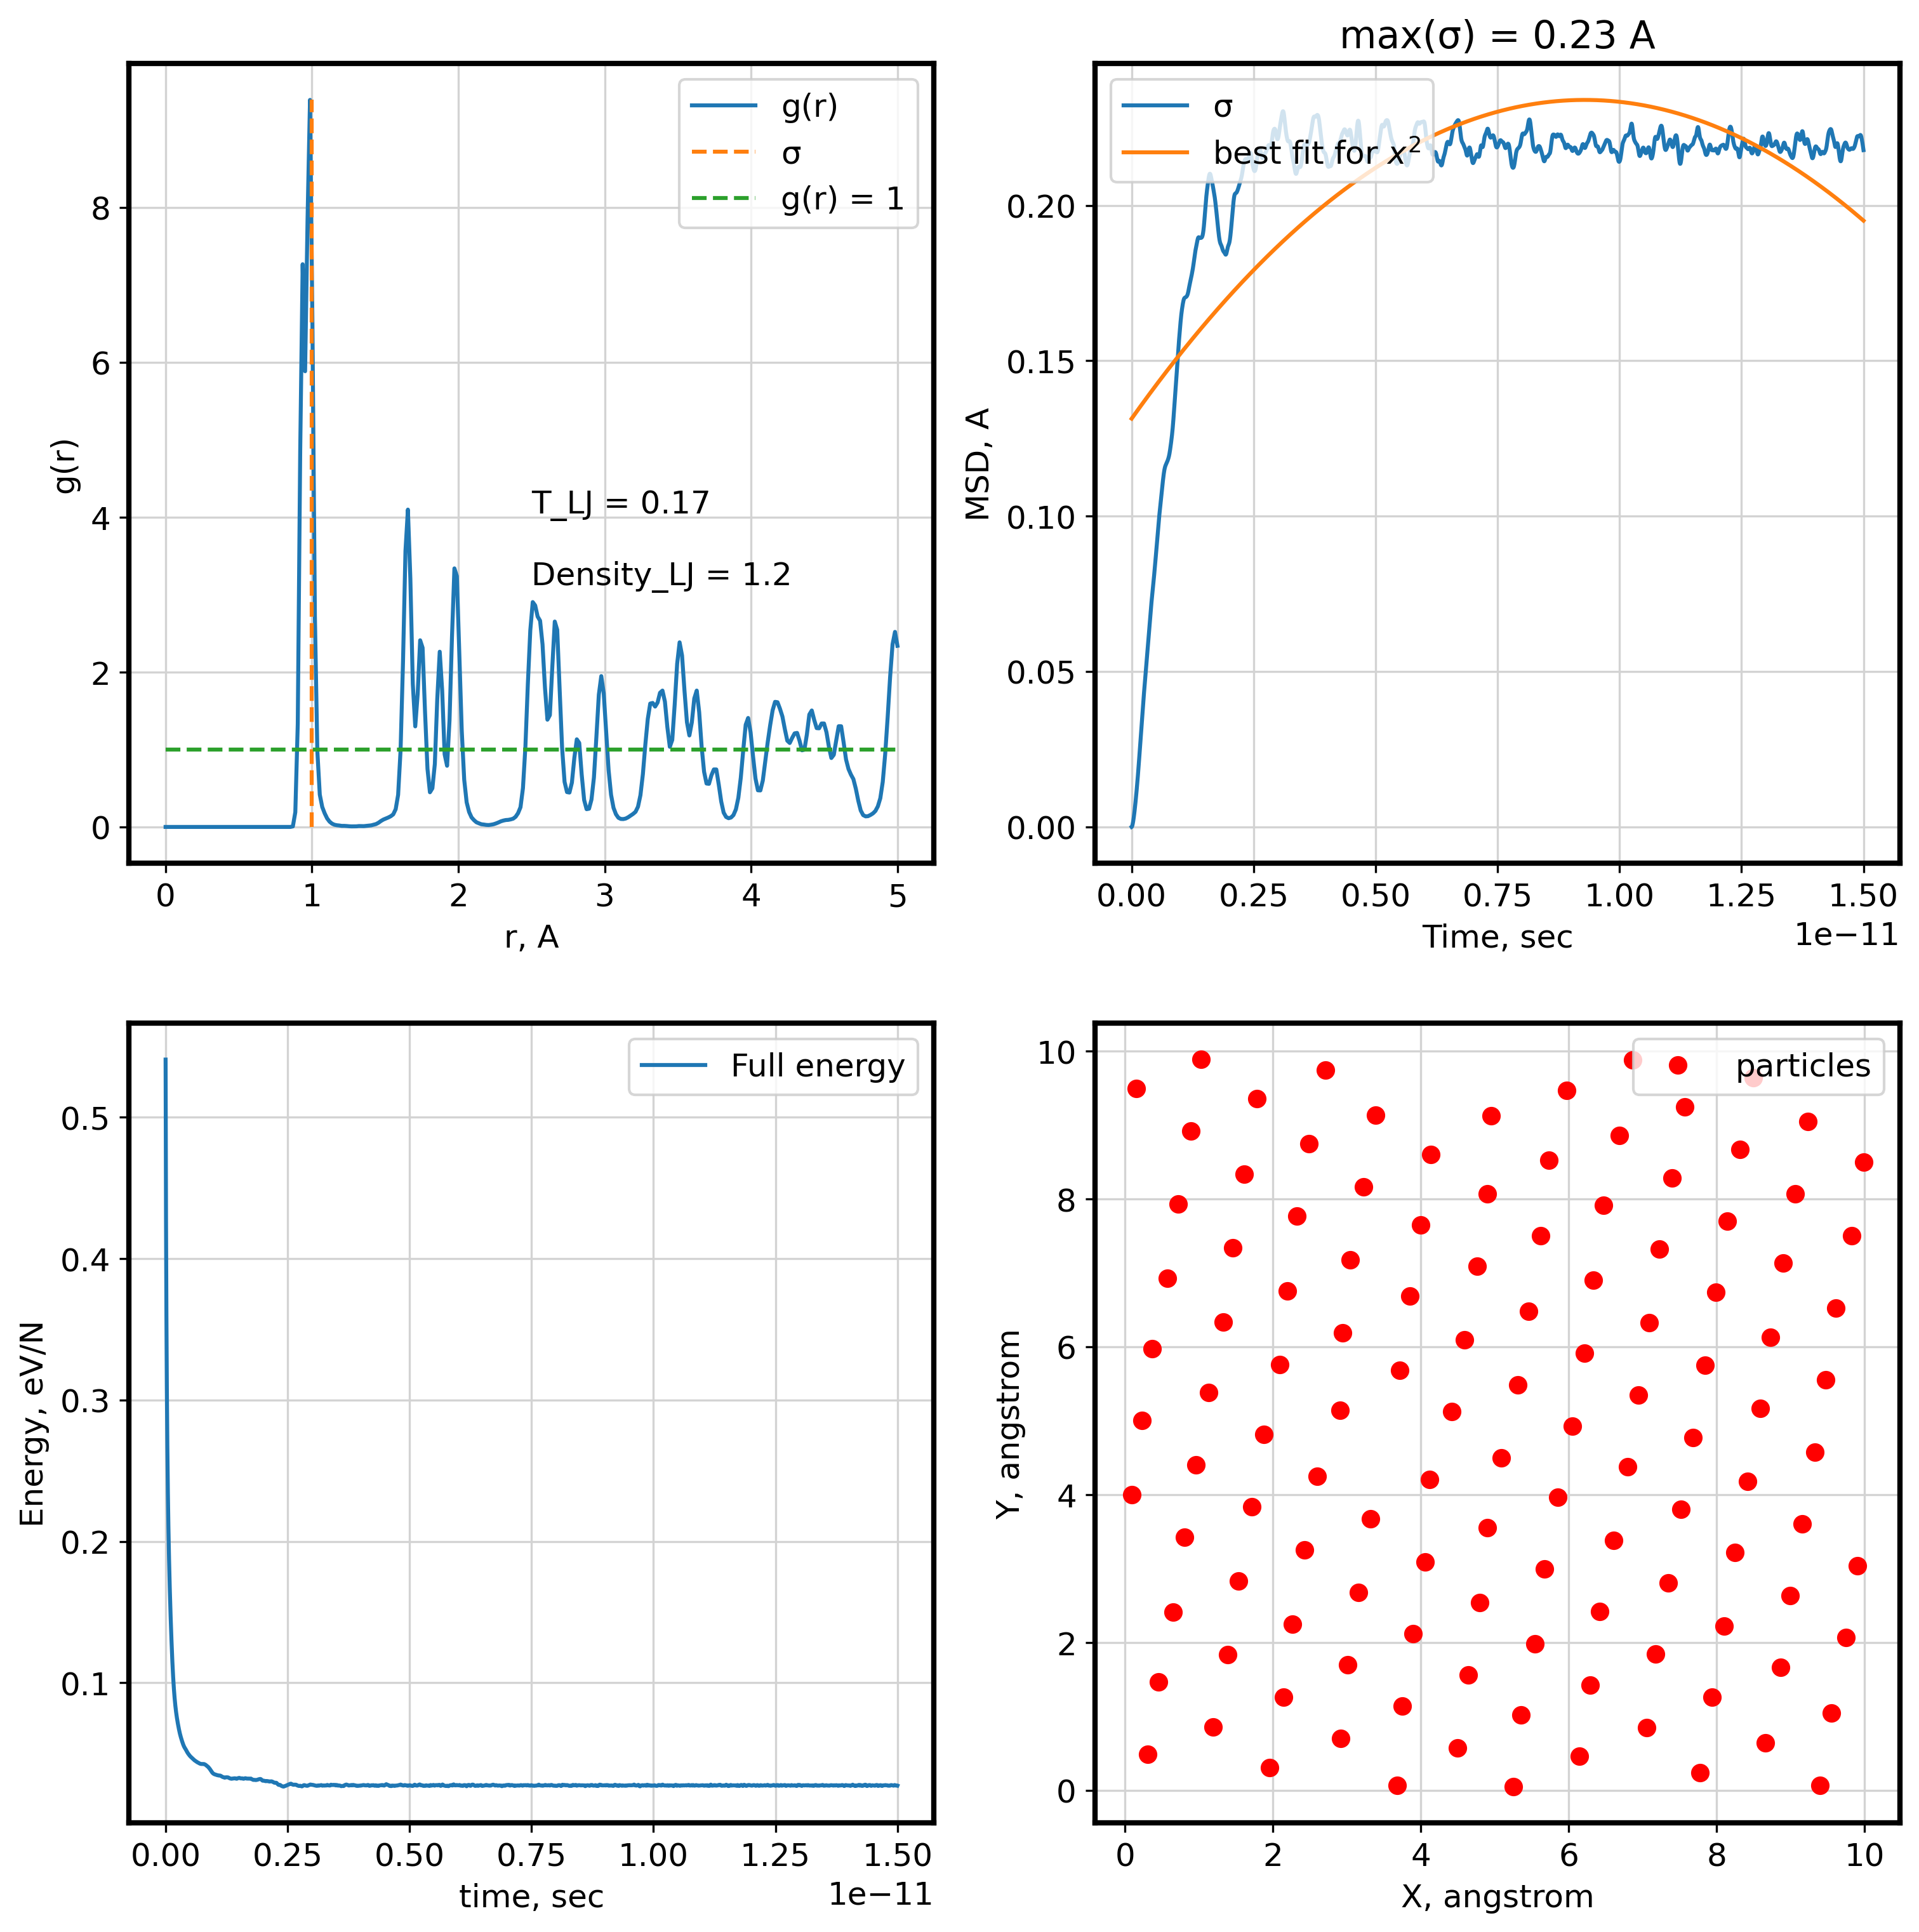

In [ ]:
Solid_model.get_plot()

#  compare methods


In [ ]:
# System
T_REQURED = 150
BOX_SIZE_X = 60
BOX_SIZE_Y = 60
BOX_SIZE_Z = 0
N_PARTICLES = [100, 500, 1000, 1500]

# Particle
MASS = 6.634e-26
SIGMA = 1
CALIBRATION_PARAMETER = 1

# Model
EPSILON = 1.653e-1
R_CUT = [4 * SIGMA, 8 * SIGMA]
TIME_STEP = 1e-15
NUMBER_OF_STEPS = 10
# Dependence of g on r parameters
RESOLUTION = 300
WARM_UP_TIME = 0

In [ ]:
work_time_dict = {}
method = ['ckdtree', 'bruteforce']

def add_element(dict, key, value):
    if key not in dict:
        dict[key] = []
    dict[key].append(value)

for idx1 in R_CUT:
  for idx2 in method:
    for idx3 in N_PARTICLES:
      Many_model = Model(nparticles=idx3, t_required=T_REQURED, box_size_x=BOX_SIZE_X, box_size_y=BOX_SIZE_Y, box_size_z=BOX_SIZE_Z, 
                    sigma=SIGMA, mass=MASS, calibration_parameter=CALIBRATION_PARAMETER)
      Many_model.run(time_step=TIME_STEP, resolution=RESOLUTION, number_of_steps=NUMBER_OF_STEPS, method=idx2,
                     thermo=False, g_of_r_method=False, MSD_method=False, warm_up_time=WARM_UP_TIME, epsilon=EPSILON, r_cut=idx1)
      add_element(work_time_dict, str(idx1)+" "+str(idx2), Many_model.run_time/NUMBER_OF_STEPS)
for key, value in work_time_dict.items():
    print(key, ' : ', value)

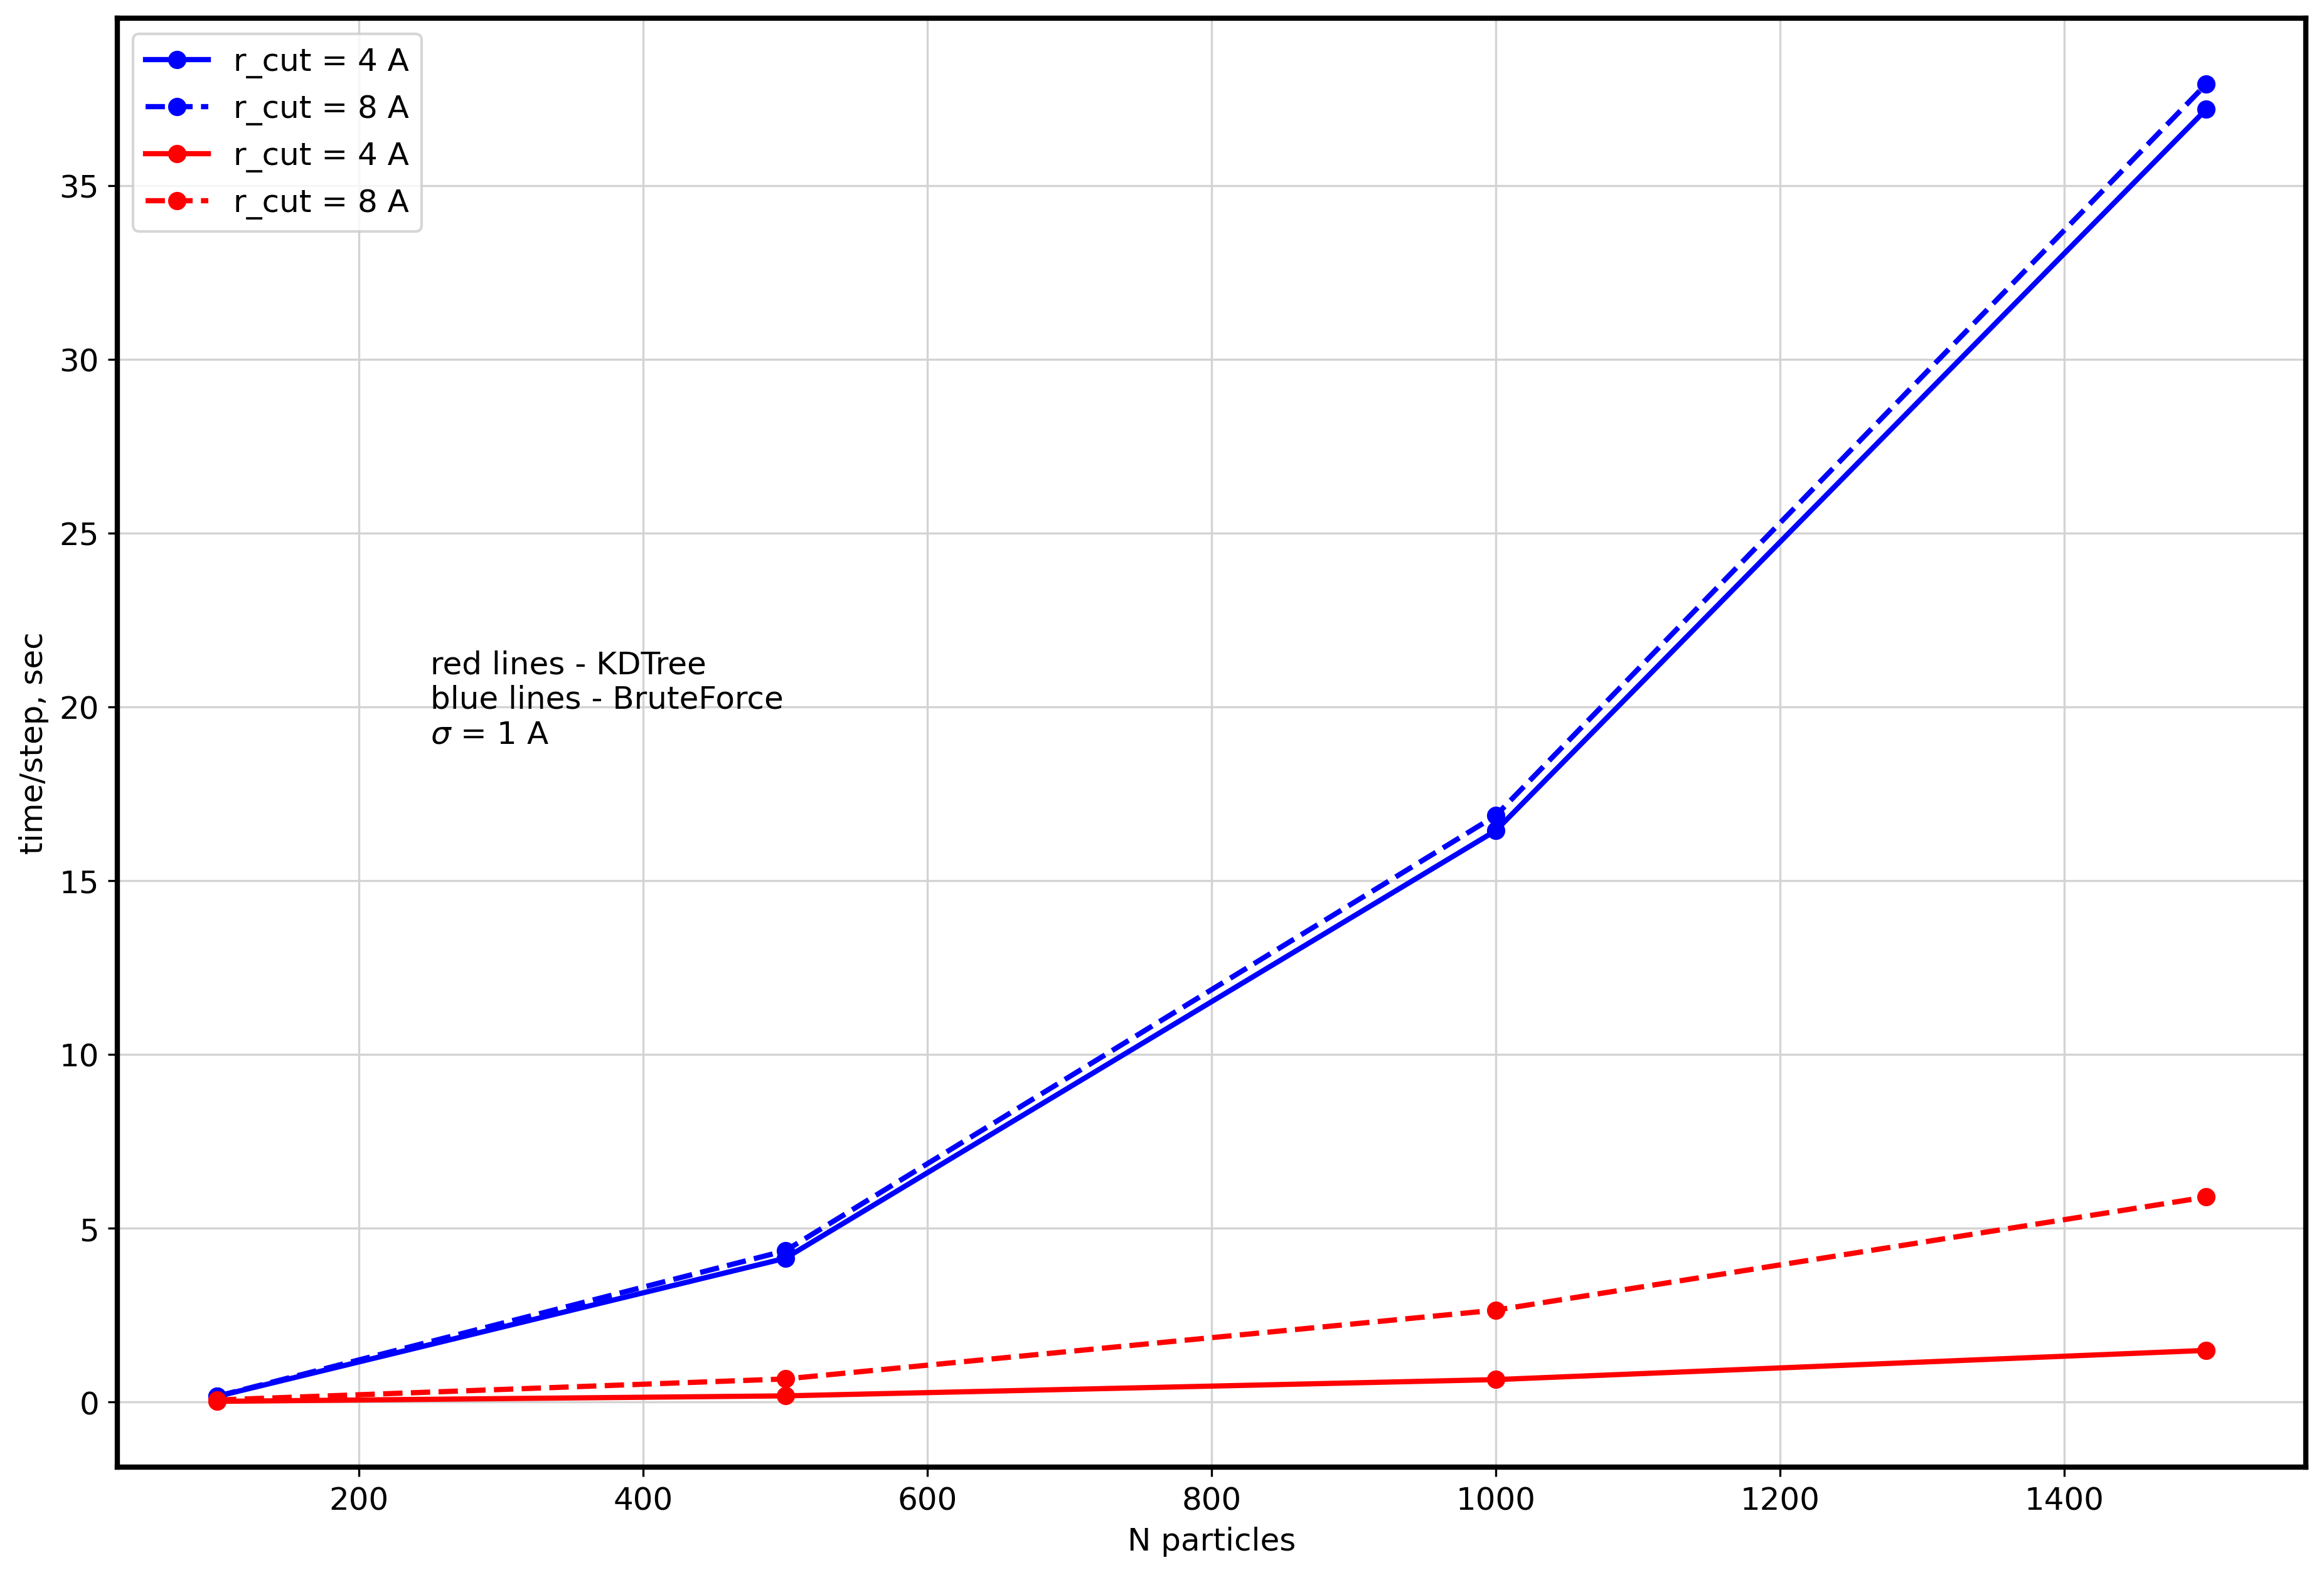

In [ ]:
plt.plot(N_PARTICLES, work_time_dict[f'{R_CUT[0]} bruteforce'], 'b', marker='o', lw=2, label=f'r_cut = {R_CUT[0]} A')
plt.plot(N_PARTICLES, work_time_dict[f'{R_CUT[1]} bruteforce'], '--b', marker='o', lw=2, label=f'r_cut = {R_CUT[1]} A')
plt.plot(N_PARTICLES, work_time_dict[f'{R_CUT[0]} ckdtree'], 'r', marker='o', lw=2, label=f'r_cut = {R_CUT[0]} A')
plt.plot(N_PARTICLES, work_time_dict[f'{R_CUT[1]} ckdtree'], '--r', marker='o', lw=2, label=f'r_cut = {R_CUT[1]} A')
plt.legend(loc='upper left')
plt.xlabel('N particles')
plt.ylabel('time/step, sec')
plt.text(N_PARTICLES[1]/2, max(max(work_time_dict.values()))/2, r'red lines - KDTree'
        '\n'
        'blue lines - BruteForce'
        '\n'
        '$\sigma$ = 1 A')
plt.show()